<a href="https://colab.research.google.com/github/achalgarg14/session_5/blob/main/Session_5_Assignment_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Import model.py from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/EVA8/Session_5')

In [ ]:
import model
from model import Net

## Data Transformations
Dataset Normalization

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std 
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


## Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders

In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


## Sample Images

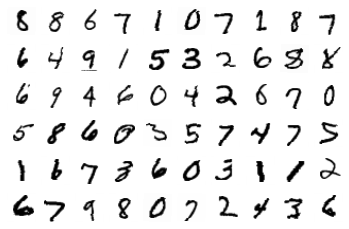

In [ ]:
# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

dataiter = iter(train_loader)
images, labels = next(dataiter)

figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Model Params
Default model is set with Batch Normalization - we will print it to see the model summary

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0

## Function to display wrong predictions

In [ ]:
import matplotlib.pyplot as plt

def display_worng_pred(wrong, n=10):
    images = wrong[:n]
    index = 0
    fig = plt.figure(figsize=(6,10))
    for img in images:
        image = img[0].squeeze().to('cpu').numpy()
        pred = img[1]
        actual = img[2]
        ax = fig.add_subplot(5, 2, index+1)
        ax.axis('off')
        ax.set_title(f'\n Predicted Label : {pred} \n Actual Label : {actual}',fontsize=10) 
        ax.imshow(image, cmap='gray_r')
        index = index + 1
    plt.show()

## Train and Test model with L1 loss addition

In [ ]:
from tqdm import tqdm
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch,lambda_l1=0):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  train_loss = 0
  
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    
    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)    

    l1 = 0
    if lambda_l1 > 0:
        for p in model.parameters():
            l1 = l1 + p.abs().sum()

    loss = loss + lambda_l1 * l1    
    
    train_loss += loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_losses.append(train_loss / len(train_loader.dataset))
  train_acc.append(100. * correct / len(train_loader.dataset))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

## Training with BN + L1 loss

In [ ]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []
wrong_pred = []

In [ ]:
from torch.optim.lr_scheduler import StepLR

model =  Net('BN').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=8, gamma=0.1)
EPOCHS = 20

lambda_l1 = 0.0001

for epoch in range(EPOCHS):
    print("EPOCH:", epoch + 1 )
    train(model, device, train_loader, optimizer, epoch,lambda_l1)
    scheduler.step()
    test(model, device, test_loader)

#mismatch data
model.eval()
for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    output = model(data)
    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    result = pred.eq(target.view_as(pred)).to('cpu').numpy()
    for j, i in enumerate(result):
      if(i == False):
        wrong_pred.append((data[j], pred[j].item(), target[j].item()))

EPOCH: 1


Loss=0.2942051291465759 Batch_id=468 Accuracy=92.34: 100%|██████████| 469/469 [00:32<00:00, 14.63it/s]



Test set: Average loss: 0.0549, Accuracy: 9828/10000 (98.28%)

EPOCH: 2


Loss=0.1767289936542511 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:30<00:00, 15.25it/s]



Test set: Average loss: 0.0461, Accuracy: 9858/10000 (98.58%)

EPOCH: 3


Loss=0.10494507849216461 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:35<00:00, 13.23it/s]



Test set: Average loss: 0.0508, Accuracy: 9847/10000 (98.47%)

EPOCH: 4


Loss=0.0978354960680008 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:38<00:00, 12.26it/s]



Test set: Average loss: 0.0478, Accuracy: 9837/10000 (98.37%)

EPOCH: 5


Loss=0.1427760124206543 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:30<00:00, 15.20it/s]



Test set: Average loss: 0.0408, Accuracy: 9863/10000 (98.63%)

EPOCH: 6


Loss=0.1625136435031891 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:30<00:00, 15.20it/s]



Test set: Average loss: 0.0401, Accuracy: 9865/10000 (98.65%)

EPOCH: 7


Loss=0.12980666756629944 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:31<00:00, 14.93it/s]



Test set: Average loss: 0.0554, Accuracy: 9836/10000 (98.36%)

EPOCH: 8


Loss=0.15985268354415894 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:30<00:00, 15.14it/s]



Test set: Average loss: 0.0346, Accuracy: 9884/10000 (98.84%)

EPOCH: 9


Loss=0.08912050724029541 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:31<00:00, 14.67it/s]



Test set: Average loss: 0.0193, Accuracy: 9932/10000 (99.32%)

EPOCH: 10


Loss=0.09077528119087219 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:32<00:00, 14.44it/s]



Test set: Average loss: 0.0182, Accuracy: 9939/10000 (99.39%)

EPOCH: 11


Loss=0.08238457143306732 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:30<00:00, 15.24it/s]



Test set: Average loss: 0.0188, Accuracy: 9938/10000 (99.38%)

EPOCH: 12


Loss=0.20858149230480194 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:30<00:00, 15.30it/s]



Test set: Average loss: 0.0193, Accuracy: 9931/10000 (99.31%)

EPOCH: 13


Loss=0.1879613995552063 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:30<00:00, 15.25it/s]



Test set: Average loss: 0.0196, Accuracy: 9939/10000 (99.39%)

EPOCH: 14


Loss=0.12247718870639801 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:30<00:00, 15.32it/s]



Test set: Average loss: 0.0199, Accuracy: 9930/10000 (99.30%)

EPOCH: 15


Loss=0.0772465318441391 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:30<00:00, 15.31it/s]



Test set: Average loss: 0.0191, Accuracy: 9937/10000 (99.37%)

EPOCH: 16


Loss=0.07196737080812454 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:32<00:00, 14.52it/s]



Test set: Average loss: 0.0199, Accuracy: 9935/10000 (99.35%)

EPOCH: 17


Loss=0.07456006109714508 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:30<00:00, 15.24it/s]



Test set: Average loss: 0.0178, Accuracy: 9941/10000 (99.41%)

EPOCH: 18


Loss=0.12196700274944305 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:30<00:00, 15.33it/s]



Test set: Average loss: 0.0176, Accuracy: 9941/10000 (99.41%)

EPOCH: 19


Loss=0.09484390169382095 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:30<00:00, 15.16it/s]



Test set: Average loss: 0.0184, Accuracy: 9938/10000 (99.38%)

EPOCH: 20


Loss=0.08670574426651001 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:38<00:00, 12.33it/s]



Test set: Average loss: 0.0180, Accuracy: 9938/10000 (99.38%)



In [ ]:
#Values of BN with l1 Losses
train_losses_BN_l1 = train_losses
test_losses_BN_l1 = test_losses
train_acc_BN_l1 = train_acc
test_acc_BN_l1 = test_acc
wrong_pred_BN_l1 = wrong_pred

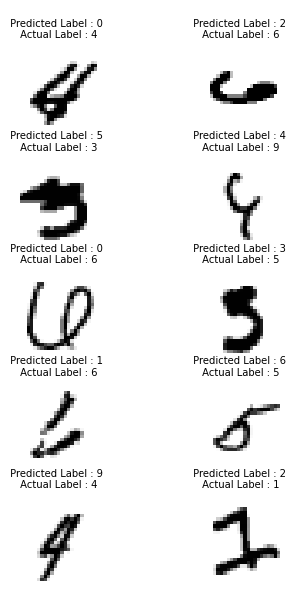

In [ ]:
display_worng_pred(wrong_pred_BN_l1)

## Training with GN loss

In [ ]:
#Initialize values for next 
train_losses = []
test_losses = []
train_acc = []
test_acc = []
wrong_pred = []

In [ ]:
model =  Net('GN').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=8, gamma=0.1)
EPOCHS = 20
lambda_l1 = 0

for epoch in range(EPOCHS):
    print("EPOCH:", epoch + 1 )
    train(model, device, train_loader, optimizer, epoch,lambda_l1)
    scheduler.step()
    test(model, device, test_loader)

#mismatch data
model.eval()
for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    output = model(data)
    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    result = pred.eq(target.view_as(pred)).to('cpu').numpy()
    for j, i in enumerate(result):
      if(i == False):
        wrong_pred.append((data[j], pred[j].item(), target[j].item()))
     

EPOCH: 1


Loss=0.06314828246831894 Batch_id=468 Accuracy=86.11: 100%|██████████| 469/469 [00:30<00:00, 15.27it/s]



Test set: Average loss: 0.0925, Accuracy: 9735/10000 (97.35%)

EPOCH: 2


Loss=0.050639476627111435 Batch_id=468 Accuracy=97.05: 100%|██████████| 469/469 [00:36<00:00, 13.00it/s]



Test set: Average loss: 0.0570, Accuracy: 9833/10000 (98.33%)

EPOCH: 3


Loss=0.03200848773121834 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:31<00:00, 14.83it/s]



Test set: Average loss: 0.0376, Accuracy: 9904/10000 (99.04%)

EPOCH: 4


Loss=0.11048182100057602 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:32<00:00, 14.26it/s]



Test set: Average loss: 0.0527, Accuracy: 9837/10000 (98.37%)

EPOCH: 5


Loss=0.1373082995414734 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:32<00:00, 14.50it/s]



Test set: Average loss: 0.0342, Accuracy: 9895/10000 (98.95%)

EPOCH: 6


Loss=0.06384030729532242 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:34<00:00, 13.41it/s]



Test set: Average loss: 0.0497, Accuracy: 9847/10000 (98.47%)

EPOCH: 7


Loss=0.13919684290885925 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:36<00:00, 12.80it/s]



Test set: Average loss: 0.0303, Accuracy: 9917/10000 (99.17%)

EPOCH: 8


Loss=0.022505396977066994 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:30<00:00, 15.30it/s]



Test set: Average loss: 0.0289, Accuracy: 9916/10000 (99.16%)

EPOCH: 9


Loss=0.07682834565639496 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:32<00:00, 14.54it/s]



Test set: Average loss: 0.0216, Accuracy: 9933/10000 (99.33%)

EPOCH: 10


Loss=0.002716458635404706 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:38<00:00, 12.28it/s]



Test set: Average loss: 0.0216, Accuracy: 9935/10000 (99.35%)

EPOCH: 11


Loss=0.021556725725531578 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:36<00:00, 12.91it/s]



Test set: Average loss: 0.0221, Accuracy: 9934/10000 (99.34%)

EPOCH: 12


Loss=0.013513542711734772 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:30<00:00, 15.24it/s]



Test set: Average loss: 0.0232, Accuracy: 9932/10000 (99.32%)

EPOCH: 13


Loss=0.006774753797799349 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:30<00:00, 15.53it/s]



Test set: Average loss: 0.0217, Accuracy: 9933/10000 (99.33%)

EPOCH: 14


Loss=0.01596921496093273 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:34<00:00, 13.77it/s]



Test set: Average loss: 0.0218, Accuracy: 9932/10000 (99.32%)

EPOCH: 15


Loss=0.04698570445179939 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:39<00:00, 11.99it/s]



Test set: Average loss: 0.0220, Accuracy: 9934/10000 (99.34%)

EPOCH: 16


Loss=0.006361147854477167 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:30<00:00, 15.28it/s]



Test set: Average loss: 0.0213, Accuracy: 9931/10000 (99.31%)

EPOCH: 17


Loss=0.006154613569378853 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:30<00:00, 15.42it/s]



Test set: Average loss: 0.0210, Accuracy: 9935/10000 (99.35%)

EPOCH: 18


Loss=0.008297697640955448 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:30<00:00, 15.18it/s]



Test set: Average loss: 0.0211, Accuracy: 9935/10000 (99.35%)

EPOCH: 19


Loss=0.04143305495381355 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:30<00:00, 15.51it/s]



Test set: Average loss: 0.0211, Accuracy: 9933/10000 (99.33%)

EPOCH: 20


Loss=0.006396051496267319 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:30<00:00, 15.26it/s]



Test set: Average loss: 0.0210, Accuracy: 9933/10000 (99.33%)



In [ ]:
#Values of GN Losses
train_losses_GN = train_losses
test_losses_GN = test_losses
train_acc_GN = train_acc
test_acc_GN = test_acc
wrong_pred_GN = wrong_pred

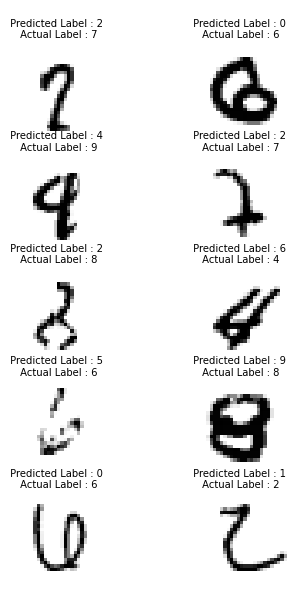

In [ ]:
display_worng_pred(wrong_pred_GN)

## Training with LN loss

In [ ]:
#Initialize values for next 
train_losses = []
test_losses = []
train_acc = []
test_acc = []
wrong_pred = []

In [ ]:
model =  Net('LN').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=8, gamma=0.1)
EPOCHS = 20
lambda_l1 = 0

for epoch in range(EPOCHS):
    print("EPOCH:", epoch + 1 )
    train(model, device, train_loader, optimizer, epoch,lambda_l1)
    scheduler.step()
    test(model, device, test_loader)

#mismatch data
model.eval()
for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    output = model(data)
    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    result = pred.eq(target.view_as(pred)).to('cpu').numpy()
    for j, i in enumerate(result):
      if(i == False):
        wrong_pred.append((data[j], pred[j].item(), target[j].item()))

EPOCH: 1


Loss=0.11039269715547562 Batch_id=468 Accuracy=86.06: 100%|██████████| 469/469 [00:32<00:00, 14.64it/s]



Test set: Average loss: 0.0977, Accuracy: 9719/10000 (97.19%)

EPOCH: 2


Loss=0.08584564924240112 Batch_id=468 Accuracy=96.70: 100%|██████████| 469/469 [00:30<00:00, 15.37it/s]



Test set: Average loss: 0.0545, Accuracy: 9842/10000 (98.42%)

EPOCH: 3


Loss=0.0667051300406456 Batch_id=468 Accuracy=97.57: 100%|██████████| 469/469 [00:30<00:00, 15.41it/s]



Test set: Average loss: 0.0909, Accuracy: 9715/10000 (97.15%)

EPOCH: 4


Loss=0.11551764607429504 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:30<00:00, 15.47it/s]



Test set: Average loss: 0.0383, Accuracy: 9884/10000 (98.84%)

EPOCH: 5


Loss=0.020686930045485497 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:30<00:00, 15.37it/s]



Test set: Average loss: 0.0345, Accuracy: 9890/10000 (98.90%)

EPOCH: 6


Loss=0.016766946762800217 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:30<00:00, 15.46it/s]



Test set: Average loss: 0.0358, Accuracy: 9891/10000 (98.91%)

EPOCH: 7


Loss=0.011852244846522808 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:32<00:00, 14.57it/s]



Test set: Average loss: 0.0372, Accuracy: 9878/10000 (98.78%)

EPOCH: 8


Loss=0.019191676750779152 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:30<00:00, 15.51it/s]



Test set: Average loss: 0.0305, Accuracy: 9899/10000 (98.99%)

EPOCH: 9


Loss=0.019877523183822632 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:30<00:00, 15.46it/s]



Test set: Average loss: 0.0244, Accuracy: 9925/10000 (99.25%)

EPOCH: 10


Loss=0.008043698035180569 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:30<00:00, 15.54it/s]



Test set: Average loss: 0.0235, Accuracy: 9928/10000 (99.28%)

EPOCH: 11


Loss=0.0035633419174700975 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:30<00:00, 15.57it/s]



Test set: Average loss: 0.0227, Accuracy: 9927/10000 (99.27%)

EPOCH: 12


Loss=0.039715077728033066 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:30<00:00, 15.41it/s]



Test set: Average loss: 0.0230, Accuracy: 9926/10000 (99.26%)

EPOCH: 13


Loss=0.034728195518255234 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:31<00:00, 14.75it/s]



Test set: Average loss: 0.0225, Accuracy: 9924/10000 (99.24%)

EPOCH: 14


Loss=0.013124842196702957 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:30<00:00, 15.61it/s]



Test set: Average loss: 0.0232, Accuracy: 9928/10000 (99.28%)

EPOCH: 15


Loss=0.09486357122659683 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:30<00:00, 15.63it/s]



Test set: Average loss: 0.0227, Accuracy: 9925/10000 (99.25%)

EPOCH: 16


Loss=0.016539452597498894 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:29<00:00, 15.67it/s]



Test set: Average loss: 0.0221, Accuracy: 9926/10000 (99.26%)

EPOCH: 17


Loss=0.006263223942369223 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:30<00:00, 15.62it/s]



Test set: Average loss: 0.0222, Accuracy: 9929/10000 (99.29%)

EPOCH: 18


Loss=0.01523636281490326 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:29<00:00, 15.70it/s]



Test set: Average loss: 0.0223, Accuracy: 9929/10000 (99.29%)

EPOCH: 19


Loss=0.002255819970741868 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:31<00:00, 14.87it/s]



Test set: Average loss: 0.0221, Accuracy: 9927/10000 (99.27%)

EPOCH: 20


Loss=0.008252738043665886 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:29<00:00, 15.68it/s]



Test set: Average loss: 0.0221, Accuracy: 9928/10000 (99.28%)



In [ ]:
#Values of LN Losses
train_losses_LN = train_losses
test_losses_LN = test_losses
train_acc_LN = train_acc
test_acc_LN = test_acc
wrong_pred_LN = wrong_pred

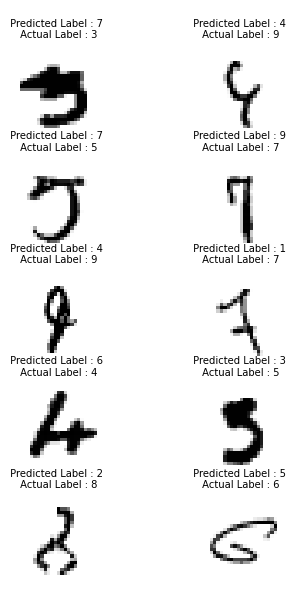

In [ ]:
display_worng_pred(wrong_pred_LN)

## Generating Graphs

In [ ]:
#Multiplying by batch size to scale
train_losses_BN_l1_2 = [value * 128 for value in train_losses_BN_l1]
train_losses_LN_2 = [value * 128 for value in train_losses_LN]
train_losses_GN_2 = [value * 128 for value in train_losses_GN]

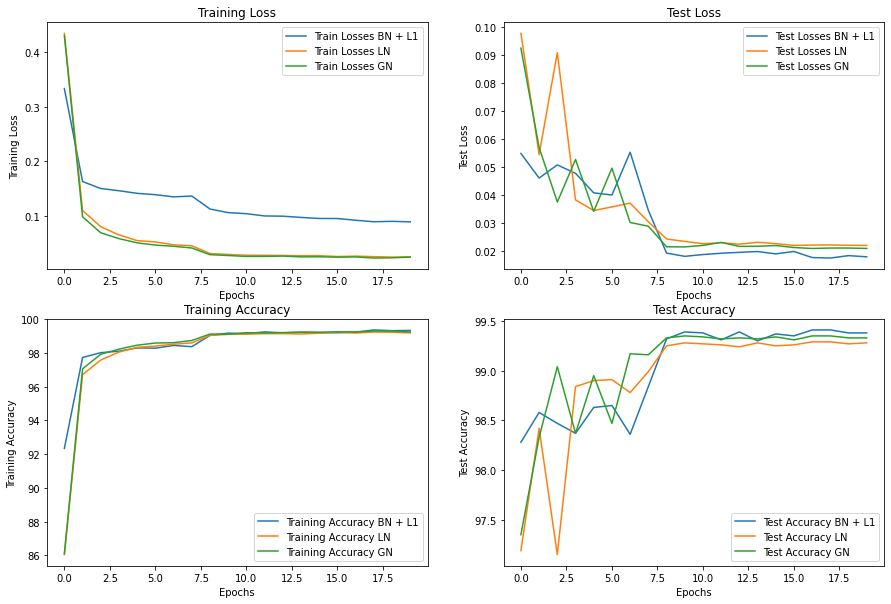

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))

axs[0, 0].plot(train_losses_BN_l1_2, label='Train Losses BN + L1')
axs[0, 0].plot(train_losses_LN_2, label='Train Losses LN')
axs[0, 0].plot(train_losses_GN_2, label='Train Losses GN')
axs[0,0].legend(loc='upper right')
axs[0,0].set_xlabel('Epochs')
axs[0,0].set_ylabel('Training Loss')
axs[0, 0].set_title("Training Loss")

axs[1, 0].plot(train_acc_BN_l1, label='Training Accuracy BN + L1')
axs[1, 0].plot(train_acc_LN, label='Training Accuracy LN')
axs[1, 0].plot(train_acc_GN, label='Training Accuracy GN')
axs[1,0].legend(loc='lower right')
axs[1,0].set_xlabel('Epochs')
axs[1,0].set_ylabel('Training Accuracy')
axs[1, 0].set_title("Training Accuracy")

axs[0, 1].plot(test_losses_BN_l1, label='Test Losses BN + L1')
axs[0, 1].plot(test_losses_LN, label='Test Losses LN')
axs[0, 1].plot(test_losses_GN, label='Test Losses GN')
axs[0,1].legend(loc='upper right')
axs[0,1].set_xlabel('Epochs')
axs[0,1].set_ylabel('Test Loss')
axs[0, 1].set_title("Test Loss")

axs[1, 1].plot(test_acc_BN_l1, label='Test Accuracy BN + L1')
axs[1, 1].plot(test_acc_LN, label='Test Accuracy LN')
axs[1, 1].plot(test_acc_GN, label='Test Accuracy GN')
axs[1,1].legend(loc='lower right')
axs[1,1].set_xlabel('Epochs')
axs[1,1].set_ylabel('Test Accuracy')
axs[1, 1].set_title("Test Accuracy")

plt.show()